This rossman can be used as study notes. It runs linearly.

# Structured and time series data

This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

**The motivation behind exploring this architecture is it's relevance to real-world application**. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *        
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/rossmann/'

## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).


glob() will grab all the csv files in the directory

In [3]:
glob(f"{PATH}*.csv")

['data/rossmann/store.csv',
 'data/rossmann/weather.csv',
 'data/rossmann/state_names.csv',
 'data/rossmann/train.csv',
 'data/rossmann/store_states.csv',
 'data/rossmann/googletrend.csv',
 'data/rossmann/test.csv']

For completeness, the implementation used to put them together is included below.

In [4]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames=glob(f"{PATH}/*.csv")

    wrote_header = False
    with open(f"{path}.csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

Feature Space:
* train: Training set provided by competition
* test: testing set

In [5]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework `pandas`. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list `tables`.

In [6]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [7]:
from IPython.display import HTML

for i, t in enumerate(tables): print("Data Frame: " +table_names[i]),display(t.head())

Data Frame: train


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


Data Frame: store


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Data Frame: store_states


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


Data Frame: state_names


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


Data Frame: googletrend


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


Data Frame: weather


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


Data Frame: test


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [8]:
for i, t in enumerate(tables): 
    print("Data Frame: " +table_names[i])
    display(DataFrameSummary(t).summary())    

Data Frame: train


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


Data Frame: store


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


Data Frame: store_states


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


Data Frame: state_names


,StateName,State
count,16,16
unique,16,16
top,Bayern,MV
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


Data Frame: googletrend


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


Data Frame: weather


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


Data Frame: test


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [9]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [10]:
len(train),len(test)

(1017209, 41088)

In [11]:
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


We turn state Holidays to booleans, to make them more convenient for modeling. We can do calculations on pandas fields using notation very similar (often identical) to numpy.

In [13]:
train.StateHoliday[:10]=='1'

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: StateHoliday, dtype: bool

In [14]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

In [15]:
train.StateHoliday.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: StateHoliday, dtype: bool

`join_df` is a function for **joining tables on specific fields**. By default, we'll be doing a **left outer join** of `right` on the `left` argument using the given fields for each table.

**Pandas does joins using the `merge` method**. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and **append a "\_y"** to those on the right.

#### Wrapper function for left.merge  
`if right_on is None: right_on = left_on` means if `join_df(train,weather, "State")` is called, both train and weather will be joined by a single field `State`.

In [16]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

### Merging Dataframes `weather` and `state_names`

Join `weather` and `state names` using the fields `weather.file` and `state_names.StateName`.

In [17]:
display(weather.head(5))

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


In [18]:
display(state_names.head(10))

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB
5,Hamburg,HH
6,Hessen,HE
7,MecklenburgVorpommern,MV
8,Niedersachsen,"HB,NI"
9,NordrheinWestfalen,NW


Note that Row 8 is `Niedersachsen` ==  `HB,NI`.

In [19]:
display(weather.head(2))

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225


In [20]:
weather = join_df(weather, state_names, "file", "StateName")

In [21]:
display(weather.iloc[:, -4:].head())

,Events,WindDirDegrees,StateName,State
0,Rain,215,NordrheinWestfalen,NW
1,Rain,225,NordrheinWestfalen,NW
2,Rain,240,NordrheinWestfalen,NW
3,Rain,263,NordrheinWestfalen,NW
4,Rain,268,NordrheinWestfalen,NW


### Creating two new columns `Date` and `State` in Dataframe `googletrend`

DF googletrend in its original form cannot be used, so we have to tranform its data.

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to **replace all instances of state name 'NI' to match the usage in the rest of the data: 'HB,NI'**. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [22]:
#googletrend.week.head()
googletrend.loc[:,["week"]].head()

,week
0,2012-12-02 - 2012-12-08
1,2012-12-09 - 2012-12-15
2,2012-12-16 - 2012-12-22
3,2012-12-23 - 2012-12-29
4,2012-12-30 - 2013-01-05


#### How to split string in a column

In [ ]:
s = pd.Series(["this is good text", "but this is even better"])

>>> s.str.split()
0           [this, is, good, text]
1    [but, this, is, even, better]
dtype: object
>>> s.str.split("random")
0          [this is good text]
1    [but this is even better]
dtype: object

>>> s.str.split(expand=True)
      0     1     2     3       4
0  this    is  good  text    None
1   but  this    is  even  better
>>> s.str.split(" is ", expand=True)
          0            1
0      this    good text
1  but this  even better

Keep only the first portion.

In [26]:
googletrend.week.head().str.split(' - ', expand=True)[0]

0    2012-12-02
1    2012-12-09
2    2012-12-16
3    2012-12-23
4    2012-12-30
Name: 0, dtype: object

In [27]:
googletrend.file.head()

0    Rossmann_DE_SN
1    Rossmann_DE_SN
2    Rossmann_DE_SN
3    Rossmann_DE_SN
4    Rossmann_DE_SN
Name: file, dtype: object

Keep the last portion.

In [28]:
googletrend.file.head().str.split('_', expand=True)[2]

0    SN
1    SN
2    SN
3    SN
4    SN
Name: 2, dtype: object

In [23]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]

Filter out rows where **State = NI**.

In [24]:
googletrend.loc[googletrend.State=='NI', "State"].head(10)

1184    NI
1185    NI
1186    NI
1187    NI
1188    NI
1189    NI
1190    NI
1191    NI
1192    NI
1193    NI
Name: State, dtype: object

In [ ]:
df
===
            max_speed  shield
cobra               1       2
viper               4       5
sidewinder          7       8


Single label. Note this returns the row as a Series.
===================================================

df.loc['viper']
max_speed    4
shield       5
Name: viper, dtype: int64

List of labels. Note using ``[[]]`` returns a DataFrame.
=======================================================

df.loc[['viper', 'sidewinder']]
            max_speed  shield
viper               4       5
sidewinder          7       8


df.loc[df['shield'] > 6, ['max_speed']]
            max_speed
sidewinder          7

Update "NI" State in googletrend to be "HB,NI" so that it is consistent with other tables, such as weather.

In [25]:
googletrend.loc[googletrend.State=='NI', ["State"]] = 'HB,NI'

In [26]:
googletrend.loc[googletrend.State=='HB,NI', ["State"]].head(10)

,State
1184,"HB,NI"
1185,"HB,NI"
1186,"HB,NI"
1187,"HB,NI"
1188,"HB,NI"
1189,"HB,NI"
1190,"HB,NI"
1191,"HB,NI"
1192,"HB,NI"
1193,"HB,NI"


Now DF `googletred` has 2 more columns `Date` and `State` that can be used as keys for merging.

In [27]:
googletrend.head()

,file,week,trend,Date,State
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN


### Expanding Date

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. **Without expanding your date-time** into these **additional fields**, you **can't capture any trend/cyclical behavior** as a function of time at any of these granularities. We'll **add** to **every table with a date field**.

There are 4 Dataframes with the field `Date`, so the same operations will be run four times on each of them.

#### weather

In [28]:
weather.loc[:,['Date']].head()

,Date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [29]:
add_datepart(weather, "Date", drop=False)

Another 13 columns added in addition to `Date`.

In [30]:
weather.iloc[:,-13:].head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
2,2013,1,1,3,3,3,False,False,False,False,False,False,1357171200
3,2013,1,1,4,4,4,False,False,False,False,False,False,1357257600
4,2013,1,1,5,5,5,False,False,False,False,False,False,1357344000


In [31]:
weather.head(2).T

,0,1
file,NordrheinWestfalen,NordrheinWestfalen
Date,2013-01-01 00:00:00,2013-01-02 00:00:00
Max_TemperatureC,8,7
Mean_TemperatureC,4,4
Min_TemperatureC,2,1
Dew_PointC,7,5
MeanDew_PointC,5,3
Min_DewpointC,1,2
Max_Humidity,94,93
Mean_Humidity,87,85


#### googletrend

Now that we had expanded `Date` in `weather`, let's do the same to `Date` in '
`googletrend`.

Note that `Date` in googletrend have data one week apart e.g. 2012-12-02, 2012,12-09 etc, so any merging using data will create many NaN. Hence it is neccessary that the DFs have columns like week, year to use as keys.

In [32]:
googletrend.loc[:, ['Date']].head(10)

,Date
0,2012-12-02
1,2012-12-09
2,2012-12-16
3,2012-12-23
4,2012-12-30
5,2013-01-06
6,2013-01-13
7,2013-01-20
8,2013-01-27
9,2013-02-03


In [33]:
add_datepart(googletrend, "Date", drop=False)

In [34]:
display(googletrend.iloc[:,-13:].head())

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
1,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
2,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
3,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
4,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


#### Train

Next we do the same to `Date` in `train`

In [35]:
train.loc[:,['Date']].head()

,Date
0,2015-07-31
1,2015-07-31
2,2015-07-31
3,2015-07-31
4,2015-07-31


In [36]:
add_datepart(train, "Date", drop=False)

Although `Date` in train is daily, we will still need `Year` and `Week` data to be used as keys. 

In [37]:
display(train.iloc[:, -13:].head())

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
1,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
2,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
3,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800
4,2015,7,31,31,4,212,True,False,False,False,False,False,1438300800


#### test

Latly, do it to `test`.

In [38]:
test.loc[:,['Date']].head()

,Date
0,2015-09-17
1,2015-09-17
2,2015-09-17
3,2015-09-17
4,2015-09-17


In [39]:
add_datepart(test, "Date", drop=False)

In [40]:
test.iloc[:,-13:].head()

,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000
1,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000
2,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000
3,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000
4,2015,9,38,17,3,260,False,False,False,False,False,False,1442448000


### Creating new dataframe from googletrend using `Rossmann_DE`

The Google trends data has a special category for the whole of the Germany, which is - `Rossmann_DE` - we'll pull that out so we can use it explicitly.


Note row 2 `Rossman_DE` is for the whole of Germany.

In [41]:
list(googletrend.file.unique())

['Rossmann_DE_SN',
 'Rossmann_DE',
 'Rossmann_DE_BY',
 'Rossmann_DE_TH',
 'Rossmann_DE_NW',
 'Rossmann_DE_BE',
 'Rossmann_DE_RP',
 'Rossmann_DE_BW',
 'Rossmann_DE_NI',
 'Rossmann_DE_SH',
 'Rossmann_DE_HE',
 'Rossmann_DE_ST',
 'Rossmann_DE_HH',
 'Rossmann_DE_SL']

Note that `State` = `None` for all rows where `file` == `Rossmann_DE`, so any future merging using `State` ,with googletrend on the right side during merging, will cause a loss of these rows. Hence a separate DF is created.

In [42]:
googletrend.loc[googletrend.file == 'Rossmann_DE', ["file","State"]].head()

,file,State
148,Rossmann_DE,None
149,Rossmann_DE,None
150,Rossmann_DE,None
151,Rossmann_DE,None
152,Rossmann_DE,None


Create a new table with only `Rossmann_DE`. This DF can be merged later so that the merged DF contained both state-level and national-level data

In [43]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [44]:
trend_de.head(0).T

""
file
week
trend
Date
State
Year
Month
Week
Day
Dayofweek


### Merging all Dataframes

Now we can outer join all of our data into a single dataframe. Recall that **in outer joins** everytime a value in the joining field on the **left** table **does not have a corresponding value** on the **right** table, the corresponding row in the new table has **Null values** for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why note just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. **However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it**. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

#### Merge `store` and `store_states`

In [45]:
store.head(2).T

,0,1
Store,1,2
StoreType,c,a
Assortment,a,a
CompetitionDistance,1270,570
CompetitionOpenSinceMonth,9,11
CompetitionOpenSinceYear,2008,2007
Promo2,0,1
Promo2SinceWeek,NaN,13
Promo2SinceYear,NaN,2010
PromoInterval,NaN,"Jan,Apr,Jul,Oct"


In [46]:
store_states.head()

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


In [47]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()]) # or np.sum(store.State.isnull() == True)

0

`store_states` is now in the joined DF `store`. The new column `State` is added to the end.

In [48]:
#store.loc[:,["Store","Promo2SinceYear","PromoInterval","State"]].head(10)
store.head(2).T

,0,1
Store,1,2
StoreType,c,a
Assortment,a,a
CompetitionDistance,1270,570
CompetitionOpenSinceMonth,9,11
CompetitionOpenSinceYear,2008,2007
Promo2,0,1
Promo2SinceWeek,NaN,13
Promo2SinceYear,NaN,2010
PromoInterval,NaN,"Jan,Apr,Jul,Oct"


#### Merge `store` and `train` into new DF `joined`

Join DF `train` and DF `store` using the field `Store`.

In [49]:
train.head(0).T

""
Store
DayOfWeek
Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday
Year


In [50]:
store.head(0).T

""
Store
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval


In [51]:
np.sum(store.isnull())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
State                          0
dtype: int64

In [52]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [53]:
np.sum(joined.isnull() == True) # Note that many NAs showed up 

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
Year                              0
Month                             0
Week                              0
Day                               0
Dayofweek                         0
Dayofyear                         0
Is_month_end                      0
Is_month_start                    0
Is_quarter_end                    0
Is_quarter_start                  0
Is_year_end                       0
Is_year_start                     0
Elapsed                           0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                      

DF `joined`, which combines `train` and `store`, now has fields such as `StoreType`, `Assortments` from DF `store`. Every store will now carry these information in the same row.

In [54]:
#joined.loc[:,["Store","DayOfWeek","Date","Sales","Customers","StoreType","Assortment","State",
#             "Elapsed","StoreType","Assortment","CompetitionDistance"]].head(10)
joined.iloc[:,-13:].head().T

,0,1,2,3,4
Is_year_end,False,False,False,False,False
Is_year_start,False,False,False,False,False
Elapsed,1438300800,1438300800,1438300800,1438300800,1438300800
StoreType,c,a,a,c,a
Assortment,a,a,a,c,a
CompetitionDistance,1270,570,14130,620,29910
CompetitionOpenSinceMonth,9,11,12,9,4
CompetitionOpenSinceYear,2008,2007,2006,2009,2015
Promo2,0,1,1,0,0
Promo2SinceWeek,NaN,13,14,NaN,NaN


#### Merge `joined` and `googletrend`

Join `joined` with `googletrend` using 3 fields `State`,`Year`, `Week`.

Take a look at all columns in googletrend

In [55]:
googletrend.iloc[[501,449,553]].T

,501,449,553
file,Rossmann_DE_TH,Rossmann_DE_TH,Rossmann_DE_TH
week,2014-01-05 - 2014-01-11,2013-01-06 - 2013-01-12,2015-01-04 - 2015-01-10
trend,78,65,65
Date,2014-01-05 00:00:00,2013-01-06 00:00:00,2015-01-04 00:00:00
State,TH,TH,TH
Year,2014,2013,2015
Month,1,1,1
Week,1,1,1
Day,5,6,4
Dayofweek,6,6,6


In [56]:
googletrend.head(2).T

,0,1
file,Rossmann_DE_SN,Rossmann_DE_SN
week,2012-12-02 - 2012-12-08,2012-12-09 - 2012-12-15
trend,96,95
Date,2012-12-02 00:00:00,2012-12-09 00:00:00
State,SN,SN
Year,2012,2012
Month,12,12
Week,48,49
Day,2,9
Dayofweek,6,6


Look at the specific columns used for merging

`State`,`Year`,`Week` from DF `googletrend`

In [57]:
googletrend.loc[:,["State","Year","Week",'trend']].head()

,State,Year,Week,trend
0,SN,2012,48,96
1,SN,2012,49,95
2,SN,2012,50,91
3,SN,2012,51,48
4,SN,2012,52,67


Merge `googletrend` with `joined` using `State`,`Year`,`Week`.

Why merge using `Week`when there are daily fields in googletrend such as `Day`,`Dayofweek`,`Dayofyear`?

Because googletrend was weekly data to begin with.

In [58]:
googletrend.loc[(googletrend.Week == 1) & (googletrend.State == "TH") & (googletrend.Year == 2014),["trend","Day","Week"]]

,trend,Day,Week
501,78,5,1


In [59]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

Some selected columns in the new `joined`

In [60]:
#joined.loc[1000:1010,["DayOfWeek","Date","Sales","Customers",
#               "Store","State","Year","Week","trend","file",
#              "Is_month_end","Is_month_start","Is_quarter_end",
#              "Day","Dayofweek" ]]

joined.loc[:4,["Store","State","Year","Week","trend"]]

,Store,State,Year,Week,trend
0,1,HE,2015,31,85
1,2,TH,2015,31,80
2,3,NW,2015,31,86
3,4,BE,2015,31,74
4,5,SN,2015,31,82


Note there exists duplicate fields such as `Day` vs `Day_y', `Elapsed` vs `Elapsed_y`, all of which will be dropped later. This is inevitable duplication because we need to use add_datepart() to expand googletrend.date into "Week" and "Year"

In [61]:
list(joined.columns)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'State',
 'file',
 'week',
 'trend',
 'Date_y',
 'Month_y',
 'Day_y',
 'Dayofweek_y',
 'Dayofyear_y',
 'Is_month_end_y',
 'Is_month_start_y',
 'Is_quarter_end_y',
 'Is_quarter_start_y',
 'Is_year_end_y',
 'Is_year_start_y',
 'Elapsed_y']

Important thing is `trend` is now attached to the correct rows based on the three fields `State`,`Year` and `Week`.

In [62]:
joined.loc[:2,["Date","State","Year","Week","trend"]]

,Date,State,Year,Week,trend
0,2015-07-31,HE,2015,31,85
1,2015-07-31,TH,2015,31,80
2,2015-07-31,NW,2015,31,86


#### Merge `joined` and `trend_de`

Join DF `joined` with DF `trend_de` using fields `Year` and `Week`. Note that `googletrend` contains only state-level data, and `trend_de` (extracted from the former) contains national data. After merging, a single row will have data at both levels.

`trend_de` came from `googletrend`, which is weekly data. Since it has no state information, it has to be merged using `year` and `week`.

In [63]:
trend_de.head(2).T

,148,149
file,Rossmann_DE,Rossmann_DE
week,2012-12-02 - 2012-12-08,2012-12-09 - 2012-12-15
trend,77,76
Date,2012-12-02 00:00:00,2012-12-09 00:00:00
State,None,None
Year,2012,2012
Month,12,12
Week,48,49
Day,2,9
Dayofweek,6,6


Note that column suffix is **_DE** and the 2 DFs are joined by two fields.

In [64]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

Check the DF `joined` after merging. There are both state level columns and national level columns (with `_DE`)

In [65]:
#joined.loc[:5,["DayOfWeek","Date",
#               "file","Is_month_end","Is_month_start","Is_quarter_end",
#               "file_DE","Is_month_end_DE","Is_month_start_DE","Is_quarter_end_DE",
#              ]].head()

joined.iloc[:,-20:].head(2).T

,0,1
Is_quarter_start_y,False,False
Is_year_end_y,False,False
Is_year_start_y,False,False
Elapsed_y,1438473600,1438473600
file_DE,Rossmann_DE,Rossmann_DE
week_DE,2015-08-02 - 2015-08-08,2015-08-02 - 2015-08-08
trend_DE,83,83
Date_DE,2015-08-02 00:00:00,2015-08-02 00:00:00
State_DE,None,None
Month_DE,8,8


In [66]:
list(joined.columns)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'State',
 'file',
 'week',
 'trend',
 'Date_y',
 'Month_y',
 'Day_y',
 'Dayofweek_y',
 'Dayofyear_y',
 'Is_month_end_y',
 'Is_month_start_y',
 'Is_quarter_end_y',
 'Is_quarter_start_y',
 'Is_year_end_y',
 'Is_year_start_y',
 'Elapsed_y',
 'file_DE',
 'week_DE',
 'trend_DE',
 'Date_DE',
 'State_DE',
 'Month_DE',
 'Day_DE',
 'Dayofweek_DE',
 'Dayofyear_DE',
 'Is_month_end_DE',
 'Is_month_start_DE',
 'Is_quarter_end_DE',
 'Is_quarter_start_DE',
 'Is_year_end_DE',
 'Is_year_start_DE',
 'Elapsed_DE']

#### Merge `joined` and `weather`

Merge `joined` with `weather`. Since `weather` is daily data showing the weather condition in different state, we will join it by `Date` and `State`.

In [67]:
weather.head(2).T

,0,1
file,NordrheinWestfalen,NordrheinWestfalen
Date,2013-01-01 00:00:00,2013-01-02 00:00:00
Max_TemperatureC,8,7
Mean_TemperatureC,4,4
Min_TemperatureC,2,1
Dew_PointC,7,5
MeanDew_PointC,5,3
Min_DewpointC,1,2
Max_Humidity,94,93
Mean_Humidity,87,85


In [68]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [69]:
#joined.loc[:5,["State","Date","Sales","Customers",
#               "Store","Year","Week","trend","file",
#              "Max_TemperatureC","Mean_TemperatureC","Dew_PointC"]].head()

joined.iloc[:2,-40:].T

,0,1
Is_year_end_DE,False,False
Is_year_start_DE,False,False
Elapsed_DE,1438473600,1438473600
file_y,Hessen,Thueringen
Max_TemperatureC,23,19
Mean_TemperatureC,16,13
Min_TemperatureC,8,7
Dew_PointC,9,9
MeanDew_PointC,6,6
Min_DewpointC,3,3


Get all the columns in `joined`

In [70]:
list(joined.columns)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'State',
 'file',
 'week',
 'trend',
 'Date_y',
 'Month_y',
 'Day_y',
 'Dayofweek_y',
 'Dayofyear_y',
 'Is_month_end_y',
 'Is_month_start_y',
 'Is_quarter_end_y',
 'Is_quarter_start_y',
 'Is_year_end_y',
 'Is_year_start_y',
 'Elapsed_y',
 'file_DE',
 'week_DE',
 'trend_DE',
 'Date_DE',
 'State_DE',
 'Month_DE',
 'Day_DE',
 'Dayofweek_DE',
 'Dayofyear_DE',
 'Is_month_end_DE',
 'Is_month_start_DE',
 'Is_quarter_end_DE',
 'Is_quarter_start_DE',
 'Is_year_end_DE',
 'Is_year_start_DE',
 'Elapsed_DE',
 'file_y',
 'Max_Tem

#### Remove repeated columns

Get rid of columns ending with `_y`. Note that all columns from new DFs using `join_df()` will have suffix `_y` by default, hence carrying the same time-series information.

In [71]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [72]:
list(joined.columns)

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'State',
 'file',
 'week',
 'trend',
 'file_DE',
 'week_DE',
 'trend_DE',
 'Date_DE',
 'State_DE',
 'Month_DE',
 'Day_DE',
 'Dayofweek_DE',
 'Dayofyear_DE',
 'Is_month_end_DE',
 'Is_month_start_DE',
 'Is_quarter_end_DE',
 'Is_quarter_start_DE',
 'Is_year_end_DE',
 'Is_year_start_DE',
 'Elapsed_DE',
 'Max_TemperatureC',
 'Mean_TemperatureC',
 'Min_TemperatureC',
 'Dew_PointC',
 'MeanDew_PointC',
 'Min_DewpointC',
 'Max_Humidity',
 'Mean_Humidity',
 'Min_Humidity',
 'Max_Sea_Level_PressurehPa',
 'Mean_Sea_Level_Pressu

In [73]:
#DataFrameSummary(joined).summary().loc[['missing'],:].T
#joined.loc[joined == NaN,(joined.isnull().sum()!=0)]
joined.isnull().sum()

Store                              0
DayOfWeek                          0
Date                               0
Sales                              0
Customers                          0
Open                               0
Promo                              0
StateHoliday                       0
SchoolHoliday                      0
Year                               0
Month                              0
Week                               0
Day                                0
Dayofweek                          0
Dayofyear                          0
Is_month_end                       0
Is_month_start                     0
Is_quarter_end                     0
Is_quarter_start                   0
Is_year_end                        0
Is_year_start                      0
Elapsed                            0
StoreType                          0
Assortment                         0
CompetitionDistance             2642
CompetitionOpenSinceMonth     323348
CompetitionOpenSinceYear      323348
P

### Replace NAs

Next we'll fill in missing values to avoid complications with `NA`'s. `NA` (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary *signal value* that doesn't otherwise appear in the data.  

So Year will be fillna() with 1900 while Month with 1 (why 1?).

In [74]:
joined.loc[:,['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceYear','Promo2SinceWeek' ]][:15]

,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,Promo2SinceYear,Promo2SinceWeek
0,2008.0,9.0,NaN,NaN
1,2007.0,11.0,2010.0,13.0
2,2006.0,12.0,2011.0,14.0
3,2009.0,9.0,NaN,NaN
4,2015.0,4.0,NaN,NaN
5,2013.0,12.0,NaN,NaN
6,2013.0,4.0,NaN,NaN
7,2014.0,10.0,NaN,NaN
8,2000.0,8.0,NaN,NaN
9,2009.0,9.0,NaN,NaN


In [75]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

After filling the `NA`s, the columns become

In [76]:
joined.loc[:15 ,['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceYear','Promo2SinceWeek']]

,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,Promo2SinceYear,Promo2SinceWeek
0,2008,9,1900,1
1,2007,11,2010,13
2,2006,12,2011,14
3,2009,9,1900,1
4,2015,4,1900,1
5,2013,12,1900,1
6,2013,4,1900,1
7,2014,10,1900,1
8,2000,8,1900,1
9,2009,9,1900,1


### Create new column `CompetitionDaysOpen` 
#### Get the number of days between when Competitors have been opened and Date 

When a competitor opened for business has an impact on sales of a store on a particular day. The longer they are opened, the more the impact. So we take the YEAR and MONTH of when they are opened, convert them to DAY, and then calculate how many days have lapsed since the sales date indicated. In order to do subtraction between dates, we have to create datetime objects.

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". 

#### i) Combining year and month data into one column

In [77]:
joined.CompetitionOpenSinceYear.head()

0    2008
1    2007
2    2006
3    2009
4    2015
Name: CompetitionOpenSinceYear, dtype: int32

In [78]:
joined.CompetitionOpenSinceMonth.head()

0     9
1    11
2    12
3     9
4     4
Name: CompetitionOpenSinceMonth, dtype: int32

Create a dictionary with 3 indexes,   
`CompetitionOpenSinceYear` = `year`,  
`CompetitionOpenSinceMonth` =`month` and  
`day` = 15. 

In [79]:
dictionary = dict(year=joined.CompetitionOpenSinceYear,
                  month=joined.CompetitionOpenSinceMonth, 
                  day=15)

Note that the dictionary.values are DF column.

In [80]:
dictionary['year'].head()

0    2008
1    2007
2    2006
3    2009
4    2015
Name: CompetitionOpenSinceYear, dtype: int32

In [81]:
dictionary['month'].head()

0     9
1    11
2    12
3     9
4     4
Name: CompetitionOpenSinceMonth, dtype: int32

In [82]:
dictionary['day']

15

Convert year, month, day to a standard datetime using pandas.

In [ ]:
>>> df = pd.DataFrame({'year': [2015, 2016],
                       'month': [2, 3],
                       'day': [4, 5]})
>>> pd.to_datetime(df)
0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]                   

In [83]:
pd.to_datetime(dict(year=joined.CompetitionOpenSinceYear,
                    month=joined.CompetitionOpenSinceMonth, 
                    day=15)).head()

0   2008-09-15
1   2007-11-15
2   2006-12-15
3   2009-09-15
4   2015-04-15
dtype: datetime64[ns]

Here we subtract this CompetitorStoreOpenSince from joined.Date to get the number of days passed since.


`df.Date.subtract` counts the number of days so far

In [91]:
#joined.Date.subtract(joined.CompetitionOpenSince).head()

0   2510 days
1   2815 days
2   3150 days
3   2145 days
4    107 days
dtype: timedelta64[ns]

adding `.dt.days.` converts the timedelta object to int64.

In [92]:
#joined.Date.subtract(joined.CompetitionOpenSince).dt.days.head()


0    2510
1    2815
2    3150
3    2145
4     107
dtype: int64

#### Combine i) and ii)

`CompetitionOpenSince` combines year and month info from `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth`.  
`CompetitionDaysOpen` counts the number of days so far

In [84]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, 
                                                     day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

Two new columns `CompetitionOpenSince` and `CompetitionDaysOpen` added to DF `joined`.

In [85]:
joined.loc[(joined.Date == "2015-07-20") |(joined.Date == "2014-07-20") , 
           ["CompetitionOpenSince","CompetitionDaysOpen","Date"]].head()

,CompetitionOpenSince,CompetitionDaysOpen,Date
12265,2008-09-15,2499,2015-07-20
12266,2007-11-15,2804,2015-07-20
12267,2006-12-15,3139,2015-07-20
12268,2009-09-15,2134,2015-07-20
12269,2015-04-15,96,2015-07-20


In [86]:
joined.loc[(joined.Date == "2015-07-20") |(joined.Date == "2014-07-20") , 
           ["CompetitionOpenSince","CompetitionDaysOpen","Date"]].tail()

,CompetitionOpenSince,CompetitionDaysOpen,Date
390650,2014-06-15,35,2014-07-20
390651,2006-04-15,3018,2014-07-20
390652,1900-01-15,41824,2014-07-20
390653,1900-01-15,41824,2014-07-20
390654,1900-01-15,41824,2014-07-20


### Error Correction

Because 1900 was used to replace NAs when creating `CompetitionOpenSince` and`CompetitionDaysOpen` , there are -negative days and large days = 42200. We'll have to replace them. 

#### Remove negative and large values

There are negative values in `CompetitionDaysOpen` and they need to be replace them with zero.

In [87]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"][:2]

687    -15
1019   -15
Name: CompetitionDaysOpen, dtype: int64

There are values earlier than 1990 (note! not 1900) in `CompetitionOpenSinceYear` and they need to be replace them with zero.

In [88]:
joined.loc[joined.CompetitionOpenSinceYear<1990,["CompetitionOpenSinceYear","CompetitionDaysOpen"]][:5]

,CompetitionOpenSinceYear,CompetitionDaysOpen
11,1900,42200
12,1900,42200
15,1900,42200
18,1900,42200
21,1900,42200


In [89]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Doublecheck any negative values in `CompetitionDaysOpen`. It should be ab empty set.

In [90]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"].head()

Series([], Name: CompetitionDaysOpen, dtype: int64)

Doublecheck the row values less than 1990 in `CompetitionOpenSinceYear`, make sure they are replaced with '0'.

In [91]:
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"].head()

11    0
12    0
15    0
18    0
21    0
Name: CompetitionDaysOpen, dtype: int64

### Create new column `CompetitionMonthsOpen`  
#### Get the number of months between when Competitors have been opened and Date 

We add `CompetitionMonthsOpen` field, limiting the maximum to 2 years (less than 24) to limit number of unique categories.

`CompetitionOpenSinceMonth` in the original dataset just shows **which month** it is. New column `CompetitionMonthsOpen` will show **how many months** have passed since competition opened.

####  Convert days to month

Convert `CompetitionDaysOpen` to months, where each month is 30 days.

In [92]:
(joined["CompetitionDaysOpen"]//30).head()

0     83
1     93
2    105
3     71
4      3
Name: CompetitionDaysOpen, dtype: int64

In [93]:
for df in (joined,joined_test):
    # Convert "CompetitionMonthsOpen" to monthly data
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    # If more than 24 months, replaced with 24 so that max value is 24
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24

In [94]:
joined.loc[:,["CompetitionDaysOpen", "CompetitionMonthsOpen"]].head(10)

,CompetitionDaysOpen,CompetitionMonthsOpen
0,2510,24
1,2815,24
2,3150,24
3,2145,24
4,107,3
5,593,19
6,837,24
7,289,9
8,5463,24
9,2145,24


Check all entries are >24 by looking at the unique values of `CompetitionMonthsOpen`.

In [95]:
print(joined.CompetitionMonthsOpen.unique())
np.sum(joined.CompetitionMonthsOpen.unique()>24)

[24  3 19  9  0 16 17  7 15 22 11 13  2 23 12  4 10  1 14 20  8 18  6 21  5]


0

### Repeat the same process for Promo dates.  
### Create new column `PromoMonthsOpen`    
### Create new column `PromoDaysOpen`    

In [96]:
#?Week(year, week) 
Week(1987, 45).tuesday()

datetime.date(1987, 11, 3)

Get Promo Year and Promo Week 

In [105]:
#df.apply(lambda x: (x.Promo2SinceYear, x.Promo2SinceWeek), axis=1)[:10]

0     (1900, 1)
1    (2011, 14)
2     (1900, 1)
3     (1900, 1)
4     (1900, 1)
5     (1900, 1)
6     (2012, 1)
7    (2010, 13)
8    (2009, 45)
9    (2011, 40)
dtype: object

Convert the tuple to Mondays.  
The Monday for 1st week of 1900 = 1900-01-01
The Monday for 4th week of 2011 = 2011-04-04

In [106]:
#df.apply(lambda x: Week(x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1)[:10]

0    1900-01-01
1    2011-04-04
2    1900-01-01
3    1900-01-01
4    1900-01-01
5    1900-01-01
6    2012-01-02
7    2010-03-29
8    2009-11-02
9    2011-10-03
dtype: object

This create the Date of the Promo `Promo2Since` and how many days passed since Promo `Promo2Days`. Took some time to run this.

In [97]:
for df in (joined,joined_test):
    # Get the Monday of a particular Week in a particular Year
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
        x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    # Calculate the number of days until now
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

Doublecheck the 2 new columns.

In [98]:
joined.loc[:, ["Promo2Since","Promo2Days" ]].head(10)

,Promo2Since,Promo2Days
0,1900-01-01,42214
1,2010-03-29,1950
2,2011-04-04,1579
3,1900-01-01,42214
4,1900-01-01,42214
5,1900-01-01,42214
6,1900-01-01,42214
7,1900-01-01,42214
8,1900-01-01,42214
9,1900-01-01,42214


**???** Why is there no attempt to create a promo counterpart to `CompetitionMonthsOpen`**???**  
Although promotions don't run for months but usually weeks only, there are some Prmo2Days are > 1500 (???).   
Note that Promo2Weeks is created below `f["Promo2Weeks"]` = `df["Promo2Days"]`//7.

#### Error Correction  
Make some corrections to the new columns.

Note: Set 25 to be the maximum weeks for `Promo2Weeks`.

In [99]:
for df in (joined,joined_test):
    
    # get rid of negative values in Promo2Days and replace with 0
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    
    # get rid of Promo2SinceYear<1990 and replace with 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    
    # Convert "Promo2Weeks" to weekly data
    df["Promo2Weeks"] = df["Promo2Days"]//7
    
    # Get rid of negative values in Promo2Weeks and replace with 0
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    
    # Get rid of Promo2Weeks>25 and replace with 25
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    

In [100]:
df.Promo2Weeks.unique()

array([ 0, 25, 24, 15, 20, 23, 14, 19, 22, 13, 18, 21, 12, 17, 11, 16, 10,  9,  8])

Time taken to save the following 2 files: **15 seconds**

In [101]:
joined.to_feather(f'{PATH}joined_final')
joined_test.to_feather(f'{PATH}joined_test_final')

## Durations: Create new data `Times since event` and `Time until event`

It is common when working with time series data to **extract data that explains relationships across rows as opposed to columns**, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

We'll define a function `get_elapsed` for cumulative counting across a sorted dataframe. Given a particular field `fld` to monitor, this function will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen. We'll see how to use this shortly.

In [102]:
joined= pd.read_feather(f'{PATH}joined_final', nthreads=1)

#### Creating a function that counts the time elapsed since

In [103]:
np.timedelta64()

numpy.timedelta64(0)

In [ ]:
?np.timedelta64

np.datetime64('2009-01-01') - np.datetime64('2008-01-01')
numpy.timedelta64(366,'D')

np.timedelta64(1,'W') / np.timedelta64(1,'D')
7.0


Code 	Meaning 	Time span (relative) 	Time span (absolute)
Y  	year 	    +/- 9.2e18 years 	[9.2e18 BC, 9.2e18 AD]
M 	month 	    +/- 7.6e17 years 	[7.6e17 BC, 7.6e17 AD]
W 	week 	    +/- 1.7e17 years 	[1.7e17 BC, 1.7e17 AD]
D 	day 	    +/- 2.5e16 years 	[2.5e16 BC, 2.5e16 AD]

zip `Store`, `SchoolHolidays` and `Date`.

In [104]:
list(zip(df.Store.values,df['SchoolHoliday'].values, df.Date.values))[:10]

[(1, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (3, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (7, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (8, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (9, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (10, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (11, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (12, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (13, 0, numpy.datetime64('2015-09-17T00:00:00.000000000')),
 (14, 0, numpy.datetime64('2015-09-17T00:00:00.000000000'))]

In [105]:
np.datetime64()

numpy.datetime64('NaT')

get_elapsed() will create new columns that reflect time since school holiday and time after school holiday 

In [106]:
def get_elapsed(fld, pre, df):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64() # a zero datetime object
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store: # if the store number changes
            last_date = np.datetime64() # set last date to zero
            last_store = s # update the new store number 
        if v: last_date = d # if schoolholiday is true, use that df.Date.values as d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

#### Pseudo code

In [ ]:
def get_elapsed(fld, pre, df):
    
    # Initialize some values
    day1 = np.timedelta64(1, 'D') # unit to use is day
    holiday_start_date = np.datetime64() # a zero datetime object i.e a datetime object == 0
    current_store_number = 0 # initial current_store_number number to 0
    res = []

    for store_number,school_holiday, actual_date in zip(df.Store.values,df[fld].values, df.Date.values):
        
        # This part is when we are dealing with a new store number
        if store_number != current_store_number: # if the store number changes
            holiday_start_date = np.datetime64() # if new store, always set
                                                 # holiday_start_date = 0                
            current_store_number = store_number # update the current_store_number 
            
        # This part is to mark the start of a new holiday for the current store   
        if school_holiday is true: holiday_start_date = actual_date 
            # if today is still a holiday, then holiday starts today
        
        # Get the number of days passed since holiday started, convert to timedelta
        res.append(((actual_date -holiday_start_date).astype('timedelta64[D]') / day1))
        
    df[pre+fld] = res

### Create elapsed columns for "Promo", "StateHoliday", "SchoolHoliday"

We'll be applying this to a subset of columns:

In [107]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

### Create Dataframe `df` to house new columns

In [108]:
df = joined[columns] # train[columns]
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


Note that the following cell is **NOT** run. This is the test set. But when run to make predictions, it wouls look as follows:

In [117]:
#df = test[columns]
#df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-09-17,1,1,False,0
1,2015-09-17,3,1,False,0
2,2015-09-17,7,1,False,0
3,2015-09-17,8,1,False,0
4,2015-09-17,9,1,False,0


In [ ]:
Let's walk through an example.

Say we're looking at School Holiday. We'll first  
1) sort by Store,   
2) sort by Date,   
3) and then call `add_elapsed('SchoolHoliday', 'After')`:  
This will apply to each row with School Holiday:
* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

2 ways to sort `Store`, `Date`: first, both ascending order.

In [109]:
df.sort_values(['Store', 'Date']).head(5)

,Date,Store,Promo,StateHoliday,SchoolHoliday
1016095,2013-01-01,1,0,True,1
1014980,2013-01-02,1,0,False,1
1013865,2013-01-03,1,0,False,1
1012750,2013-01-04,1,0,False,1
1011635,2013-01-05,1,0,False,1


Second, sort `Store` in ascending order but `Date` in descending oder.

In [110]:
df.sort_values(['Store', 'Date'], ascending=[True, False]).head(5)

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-07-31,1,1,False,1
1115,2015-07-30,1,1,False,1
2230,2015-07-29,1,1,False,1
3345,2015-07-28,1,1,False,1
4460,2015-07-27,1,1,False,1


In [111]:
fld = 'SchoolHoliday'
# sort by Store, sort by Date
df = df.sort_values(['Store', 'Date'])

# create 'SchoolHolidayAfter'
get_elapsed(fld, 'After', df)

# sort by Store in ascending order, sort by Date in descending order
df = df.sort_values(['Store', 'Date'], ascending=[True, False])

# create 'SchoolHolidayBefore'
get_elapsed(fld, 'Before', df)

#### Useful!!! 
df = df.sort_values(['Store', 'Date'], ascending=`[True, False])`  
Sort by Store in **ascending** order, sort by Date in **descending** order

`School Holiday` ends **2013-01-11**, so `AfterSchoolHoliday` starts counting from 1 to 9 and beyond until the next holiday.

In [112]:
df = df.sort_values(['Store', 'Date'])
df.iloc[8:20,[0,1,4,5]]

,Date,Store,SchoolHoliday,AfterSchoolHoliday
1007175,2013-01-09,1,1,0.0
1006060,2013-01-10,1,1,0.0
1004945,2013-01-11,1,1,0.0
1003830,2013-01-12,1,0,1.0
1002715,2013-01-13,1,0,2.0
1001600,2013-01-14,1,0,3.0
1000485,2013-01-15,1,0,4.0
999370,2013-01-16,1,0,5.0
998255,2013-01-17,1,0,6.0
997140,2013-01-18,1,0,7.0


School Holiday ends on 2013-03-24, so the counter stops at 72 and reset to 0 the next day.

In [113]:
df = df.sort_values(['Store', 'Date'])
df.iloc[80:90,[0,1,4,5]]

,Date,Store,SchoolHoliday,AfterSchoolHoliday
926895,2013-03-22,1,0,70.0
925780,2013-03-23,1,0,71.0
924665,2013-03-24,1,0,72.0
923550,2013-03-25,1,1,0.0
922435,2013-03-26,1,1,0.0
921320,2013-03-27,1,1,0.0
920205,2013-03-28,1,1,0.0
919090,2013-03-29,1,1,0.0
917975,2013-03-30,1,0,1.0
916860,2013-03-31,1,0,2.0


Let's look at `BeforeSchoolHoliday`. School Holiday starts 2014-07-28.

In [114]:
df.iloc[558:578,[0,1,4,6]]

,Date,Store,SchoolHoliday,BeforeSchoolHoliday
396265,2014-07-13,1,0,-15.0
395330,2014-07-14,1,0,-14.0
394395,2014-07-15,1,0,-13.0
393460,2014-07-16,1,0,-12.0
392525,2014-07-17,1,0,-11.0
391590,2014-07-18,1,0,-10.0
390655,2014-07-19,1,0,-9.0
389720,2014-07-20,1,0,-8.0
388785,2014-07-21,1,0,-7.0
387850,2014-07-22,1,0,-6.0


We'll do this for two more fields, based on State Holidays.

In [115]:
fld = 'StateHoliday'
# sort by Store, sort by Date
df = df.sort_values(['Store', 'Date'])
# create 'StateHolidayAfter'
get_elapsed(fld, 'After',df)
# sort by Store in ascending order, sort by Date in descending order
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
# create 'StateHolidayBefore'
get_elapsed(fld, 'Before',df)

2013-01-01 is a State Holiday, and the next one is 86 days away. Both counters `AfterStateHoliday` and `BeforeStateHoliday` start their count. 

In [116]:
df = df.sort_values(['Store', 'Date'])
df.iloc[:10, [0,1,3,-2,-1]]

,Date,Store,StateHoliday,AfterStateHoliday,BeforeStateHoliday
1016095,2013-01-01,1,True,0.0,0.0
1014980,2013-01-02,1,False,1.0,-86.0
1013865,2013-01-03,1,False,2.0,-85.0
1012750,2013-01-04,1,False,3.0,-84.0
1011635,2013-01-05,1,False,4.0,-83.0
1010520,2013-01-06,1,False,5.0,-82.0
1009405,2013-01-07,1,False,6.0,-81.0
1008290,2013-01-08,1,False,7.0,-80.0
1007175,2013-01-09,1,False,8.0,-79.0
1006060,2013-01-10,1,False,9.0,-78.0


Based on Promo

In [117]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After',df)
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before',df)

Note that 2013-01-01 to 2013-01-06 will show NaN, because only on 2013-01-07 did the first ever promo start, so get_elapsed() is unable to calculate rolling sum before then.

In [118]:
df = df.sort_values(['Store', 'Date'])
df.iloc[:20, [0,1,2,-2,-1]]

,Date,Store,Promo,AfterPromo,BeforePromo
1016095,2013-01-01,1,0,NaN,-6.0
1014980,2013-01-02,1,0,NaN,-5.0
1013865,2013-01-03,1,0,NaN,-4.0
1012750,2013-01-04,1,0,NaN,-3.0
1011635,2013-01-05,1,0,NaN,-2.0
1010520,2013-01-06,1,0,NaN,-1.0
1009405,2013-01-07,1,1,0.0,0.0
1008290,2013-01-08,1,1,0.0,0.0
1007175,2013-01-09,1,1,0.0,0.0
1006060,2013-01-10,1,1,0.0,0.0


### Replace NAs with 0

#### Must the index be reset to run fillna() ???

In [306]:
#df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

Replace all NAs to 0

In [129]:
#columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [127]:
#for o in ['Before', 'After']:
#    for p in columns:
#        a = o+p
#        df[a] = df[a].fillna(0).astype(int)

In [119]:
columns = ['BeforeSchoolHoliday', 'BeforeStateHoliday', 'BeforePromo',
           'AfterSchoolHoliday', 'AfterStateHoliday', 'AfterPromo']

In [120]:
for col in columns:
    df[col] = df[col].fillna(0).astype(int)

Check that the NaN are replaced,

In [121]:
np.sum(df.isnull())

Date                   0
Store                  0
Promo                  0
StateHoliday           0
SchoolHoliday          0
AfterSchoolHoliday     0
BeforeSchoolHoliday    0
AfterStateHoliday      0
BeforeStateHoliday     0
AfterPromo             0
BeforePromo            0
dtype: int64

In [122]:
df = df.reset_index()

feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s). If you have set index (eg `df = df.set_index("Date")`, you have to reset it using `df = df.reset_index()`

In [123]:
df.to_feather(f'{PATH}/df_final')

In [124]:
df.columns

Index(['index', 'Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'AfterSchoolHoliday', 'BeforeSchoolHoliday', 'AfterStateHoliday',
       'BeforeStateHoliday', 'AfterPromo', 'BeforePromo'],
      dtype='object')

### Do the same for test

In [125]:
joined_test= pd.read_feather(f'{PATH}joined_test_final', nthreads=1)

In [126]:
joined_test.head(2).T

,0,1
Id,1,2
Store,1,3
DayOfWeek,4,4
Date,2015-09-17 00:00:00,2015-09-17 00:00:00
Open,1,1
Promo,1,1
StateHoliday,False,False
SchoolHoliday,0,0
Year,2015,2015
Month,9,9


In [127]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

In [128]:
df1 = joined_test[columns]
df1.columns

Index(['Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday'], dtype='object')

In [129]:
df1.sort_values(['Store', 'Date']).head(5)

,Date,Store,Promo,StateHoliday,SchoolHoliday
40232,2015-08-01,1,0,False,1
39376,2015-08-02,1,0,False,1
38520,2015-08-03,1,1,False,1
37664,2015-08-04,1,1,False,1
36808,2015-08-05,1,1,False,1


In [130]:
df1.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday
0,2015-09-17,1,1,False,0
1,2015-09-17,3,1,False,0
2,2015-09-17,7,1,False,0
3,2015-09-17,8,1,False,0
4,2015-09-17,9,1,False,0


In [131]:
fld = 'SchoolHoliday'
df1 = df1.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After',df1)
df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before',df1)

In [132]:
fld = 'StateHoliday'
df1 = df1.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After',df1)
df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before',df1)

In [133]:
fld = 'Promo'
df1 = df1.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After',df1)
df1 = df1.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before',df1)

In [134]:
#df1 = df1.set_index("Date")

In [135]:
np.sum(df1.isnull())

Date                       0
Store                      0
Promo                      0
StateHoliday               0
SchoolHoliday              0
AfterSchoolHoliday      1444
BeforeSchoolHoliday    16782
AfterStateHoliday      34968
BeforeStateHoliday     38388
AfterPromo              1712
BeforePromo                0
dtype: int64

In [136]:
columns = ['BeforeSchoolHoliday', 'BeforeStateHoliday', 'BeforePromo',
           'AfterSchoolHoliday', 'AfterStateHoliday', 'AfterPromo']

In [137]:
for col in columns:
    df1[col] = df1[col].fillna(0).astype(int)

In [138]:
np.sum(df1.isnull())

Date                   0
Store                  0
Promo                  0
StateHoliday           0
SchoolHoliday          0
AfterSchoolHoliday     0
BeforeSchoolHoliday    0
AfterStateHoliday      0
BeforeStateHoliday     0
AfterPromo             0
BeforePromo            0
dtype: int64

In [139]:
df1 = df1.reset_index()

feather does not support serializing a non-default index for the index; you can .reset_index() to make the index into column(s). If you have set index (eg `df = df.set_index("Date")`, you have to reset it using `df = df.reset_index()`

In [140]:
df1.to_feather(f'{PATH}/df1_final')

In [141]:
df1.columns

Index(['index', 'Date', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'AfterSchoolHoliday', 'BeforeSchoolHoliday', 'AfterStateHoliday',
       'BeforeStateHoliday', 'AfterPromo', 'BeforePromo'],
      dtype='object')

## Rolling Quantities

### Create Window Functions: Moving Average-like Quantities

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're   
sorting by date (`sort_index()`) and   
counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`),  
grouped by Store (`groupby()`).   
  
We do the same in the opposite direction.

In [142]:
df = pd.read_feather(f'{PATH}/df_final')

First set the index based on `Data`, by which sorting will occur.

In [143]:
# columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

# These columns will be dropped later after the rolling-quantities are created. 
# Only Store and Date will be used for merging

In [144]:
df = df.set_index("Date")

In [145]:
df.columns

Index(['index', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'AfterSchoolHoliday', 'BeforeSchoolHoliday', 'AfterStateHoliday',
       'BeforeStateHoliday', 'AfterPromo', 'BeforePromo'],
      dtype='object')

In [146]:
df[['Store']+columns].sort_values(by=['Store','Date']).head(20)

,Store,SchoolHoliday,StateHoliday,Promo
Date,,,,
2013-01-01,1,1,True,0
2013-01-02,1,1,False,0
2013-01-03,1,1,False,0
2013-01-04,1,1,False,0
2013-01-05,1,1,False,0
2013-01-06,1,1,False,0
2013-01-07,1,1,False,1
2013-01-08,1,1,False,1
2013-01-09,1,1,False,1


In [147]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd.head(15) 

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2013-01-01    1.0            1.0           1.0    0.0
      2013-01-02    2.0            2.0           1.0    0.0
      2013-01-03    3.0            3.0           1.0    0.0
      2013-01-04    4.0            4.0           1.0    0.0
      2013-01-05    5.0            5.0           1.0    0.0
      2013-01-06    6.0            6.0           1.0    0.0
      2013-01-07    7.0            7.0           1.0    1.0
      2013-01-08    7.0            7.0           0.0    2.0
      2013-01-09    7.0            7.0           0.0    3.0
      2013-01-10    7.0            7.0           0.0    4.0
      2013-01-11    7.0            7.0           0.0    5.0
      2013-01-12    7.0            6.0           0.0    5.0
      2013-01-13    7.0            5.0           0.0    5.0
      2013-01-14    7.0            4.0           0.0    4.0
      2013-01-15    7.0            3.0           0.0    3.0

In [148]:
fwd = df[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd.head(15)

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-07-31    1.0            1.0           0.0    1.0
      2015-07-30    2.0            2.0           0.0    2.0
      2015-07-29    3.0            3.0           0.0    3.0
      2015-07-28    4.0            4.0           0.0    4.0
      2015-07-27    5.0            5.0           0.0    5.0
      2015-07-26    6.0            5.0           0.0    5.0
      2015-07-25    7.0            5.0           0.0    5.0
      2015-07-24    7.0            4.0           0.0    4.0
      2015-07-23    7.0            3.0           0.0    3.0
      2015-07-22    7.0            2.0           0.0    2.0
      2015-07-21    7.0            1.0           0.0    1.0
      2015-07-20    7.0            0.0           0.0    0.0
      2015-07-19    7.0            0.0           0.0    0.0
      2015-07-18    7.0            0.0           0.0    0.0
      2015-07-17    7.0            0.0           0.0    1.0

Drop `Store` since its rolling sum is meaningless. Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

Drop the column `Store`, where 1 means column (axis = 1)

In [149]:
#bwd.drop('Store',1,inplace=True)
#bwd.head(10)

In [150]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
bwd.head(10)

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0
5,1,2013-01-06,6.0,1.0,0.0
6,1,2013-01-07,7.0,1.0,1.0
7,1,2013-01-08,7.0,0.0,2.0
8,1,2013-01-09,7.0,0.0,3.0
9,1,2013-01-10,7.0,0.0,4.0


In [151]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [152]:
fwd.head(10)

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2015-07-31,1.0,0.0,1.0
1,1,2015-07-30,2.0,0.0,2.0
2,1,2015-07-29,3.0,0.0,3.0
3,1,2015-07-28,4.0,0.0,4.0
4,1,2015-07-27,5.0,0.0,5.0
5,1,2015-07-26,5.0,0.0,5.0
6,1,2015-07-25,5.0,0.0,5.0
7,1,2015-07-24,4.0,0.0,4.0
8,1,2015-07-23,3.0,0.0,3.0
9,1,2015-07-22,2.0,0.0,2.0


In [153]:
df.drop('index',1,inplace=True)

In [154]:
df.reset_index(inplace=True)

In [155]:
df.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
0,2013-01-01,1,0,True,1,0,0,0,0,0,-6
1,2013-01-02,1,0,False,1,0,0,1,-86,0,-5
2,2013-01-03,1,0,False,1,0,0,2,-85,0,-4
3,2013-01-04,1,0,False,1,0,0,3,-84,0,-3
4,2013-01-05,1,0,False,1,0,0,4,-83,0,-2


Now we'll merge these values onto the df.

In [156]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [157]:
df.head(2).T

,0,1
Date,2013-01-01 00:00:00,2013-01-02 00:00:00
Store,1,1
Promo,0,0
StateHoliday,True,False
SchoolHoliday,1,1
AfterSchoolHoliday,0,0
BeforeSchoolHoliday,0,0
AfterStateHoliday,0,1
BeforeStateHoliday,0,-86
AfterPromo,0,0


Drop columns `SchoolHoliday`, `StateHoliday` and `Promo` in DF `df`, as they already exist in DF `joined`

In [158]:
df.drop(columns,1,inplace=True)

`df` will contain only wrangled columns plus `Store` and `Date`.

In [159]:
df.head(2).T

,0,1
Date,2013-01-01 00:00:00,2013-01-02 00:00:00
Store,1,1
AfterSchoolHoliday,0,0
BeforeSchoolHoliday,0,0
AfterStateHoliday,0,1
BeforeStateHoliday,0,-86
AfterPromo,0,0
BeforePromo,-6,-5
SchoolHoliday_bw,1,2
StateHoliday_bw,1,1


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [144]:
#df.to_feather(f'{PATH}df')

In [145]:
#df = pd.read_feather(f'{PATH}df')

In [146]:
#df.Date.head()

0   2013-01-01
1   2013-01-02
2   2013-01-03
3   2013-01-04
4   2013-01-05
Name: Date, dtype: datetime64[ns]

In [160]:
df["Date"] = pd.to_datetime(df.Date)

In [148]:
#df["Date"].head()

0   2013-01-01
1   2013-01-02
2   2013-01-03
3   2013-01-04
4   2013-01-05
Name: Date, dtype: datetime64[ns]

In [161]:
list(df.columns)

['Date',
 'Store',
 'AfterSchoolHoliday',
 'BeforeSchoolHoliday',
 'AfterStateHoliday',
 'BeforeStateHoliday',
 'AfterPromo',
 'BeforePromo',
 'SchoolHoliday_bw',
 'StateHoliday_bw',
 'Promo_bw',
 'SchoolHoliday_fw',
 'StateHoliday_fw',
 'Promo_fw']

### Merge `df` and `joined`

Merge `joined` and `df` by fields 'Store' and `Date` so that we have a DF with the original columns, as well as the wrangled ones.

In [162]:
joinedmerged = join_df(joined, df, ['Store', 'Date'])

In [163]:
joinedmerged.to_feather(f'{PATH}/joinedmerged_final')

## Create the same process for test

#### Rolling Quantities

In [164]:
df1 = pd.read_feather(f'{PATH}/df1_final')

In [165]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [166]:
df1 = df1.set_index("Date")

In [167]:
df1.columns

Index(['index', 'Store', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'AfterSchoolHoliday', 'BeforeSchoolHoliday', 'AfterStateHoliday',
       'BeforeStateHoliday', 'AfterPromo', 'BeforePromo'],
      dtype='object')

In [168]:
df1[['Store']+columns].sort_values(by=['Store','Date']).head(20)

,Store,SchoolHoliday,StateHoliday,Promo
Date,,,,
2015-08-01,1,1,False,0
2015-08-02,1,1,False,0
2015-08-03,1,1,False,1
2015-08-04,1,1,False,1
2015-08-05,1,1,False,1
2015-08-06,1,1,False,1
2015-08-07,1,1,False,1
2015-08-08,1,1,False,0
2015-08-09,1,1,False,0


In [169]:
bwd1 = df1[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd1.head(15) 

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-08-01    1.0            1.0           0.0    0.0
      2015-08-02    2.0            2.0           0.0    0.0
      2015-08-03    3.0            3.0           0.0    1.0
      2015-08-04    4.0            4.0           0.0    2.0
      2015-08-05    5.0            5.0           0.0    3.0
      2015-08-06    6.0            6.0           0.0    4.0
      2015-08-07    7.0            7.0           0.0    5.0
      2015-08-08    7.0            7.0           0.0    5.0
      2015-08-09    7.0            7.0           0.0    5.0
      2015-08-10    7.0            7.0           0.0    4.0
      2015-08-11    7.0            7.0           0.0    3.0
      2015-08-12    7.0            7.0           0.0    2.0
      2015-08-13    7.0            7.0           0.0    1.0
      2015-08-14    7.0            7.0           0.0    0.0
      2015-08-15    7.0            7.0           0.0    0.0

In [170]:
fwd1 = df1[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd1.head(15)

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2015-09-17    1.0            0.0           0.0    1.0
      2015-09-16    2.0            0.0           0.0    2.0
      2015-09-15    3.0            0.0           0.0    3.0
      2015-09-14    4.0            0.0           0.0    4.0
      2015-09-13    5.0            0.0           0.0    4.0
      2015-09-12    6.0            0.0           0.0    4.0
      2015-09-11    7.0            0.0           0.0    4.0
      2015-09-10    7.0            0.0           0.0    3.0
      2015-09-09    7.0            0.0           0.0    2.0
      2015-09-08    7.0            0.0           0.0    1.0
      2015-09-07    7.0            0.0           0.0    0.0
      2015-09-06    7.0            0.0           0.0    0.0
      2015-09-05    7.0            0.0           0.0    0.0
      2015-09-04    7.0            1.0           0.0    1.0
      2015-09-03    7.0            2.0           0.0    2.0

Drop `Store` since its rolling sum is meaningless. Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

Drop the column `Store`, where 1 means column (axis = 1)

In [171]:
#bwd.drop('Store',1,inplace=True)
#bwd.head(10)

In [172]:
bwd1.drop('Store',1,inplace=True)
bwd1.reset_index(inplace=True)
bwd1.head(10)

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2015-08-01,1.0,0.0,0.0
1,1,2015-08-02,2.0,0.0,0.0
2,1,2015-08-03,3.0,0.0,1.0
3,1,2015-08-04,4.0,0.0,2.0
4,1,2015-08-05,5.0,0.0,3.0
5,1,2015-08-06,6.0,0.0,4.0
6,1,2015-08-07,7.0,0.0,5.0
7,1,2015-08-08,7.0,0.0,5.0
8,1,2015-08-09,7.0,0.0,5.0
9,1,2015-08-10,7.0,0.0,4.0


In [173]:
fwd1.drop('Store',1,inplace=True)
fwd1.reset_index(inplace=True)

In [174]:
fwd1.head(10)

,Store,Date,SchoolHoliday,StateHoliday,Promo
0,1,2015-09-17,0.0,0.0,1.0
1,1,2015-09-16,0.0,0.0,2.0
2,1,2015-09-15,0.0,0.0,3.0
3,1,2015-09-14,0.0,0.0,4.0
4,1,2015-09-13,0.0,0.0,4.0
5,1,2015-09-12,0.0,0.0,4.0
6,1,2015-09-11,0.0,0.0,4.0
7,1,2015-09-10,0.0,0.0,3.0
8,1,2015-09-09,0.0,0.0,2.0
9,1,2015-09-08,0.0,0.0,1.0


In [175]:
df1.drop('index',1,inplace=True)

In [176]:
df1.reset_index(inplace=True)

In [177]:
df1.head()

,Date,Store,Promo,StateHoliday,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo
0,2015-09-17,1,1,False,0,13,0,0,0,0,0
1,2015-09-16,1,1,False,0,12,0,0,0,0,0
2,2015-09-15,1,1,False,0,11,0,0,0,0,0
3,2015-09-14,1,1,False,0,10,0,0,0,0,0
4,2015-09-13,1,0,False,0,9,0,0,0,9,-1


Now we'll merge these values onto the df.

In [178]:
df1 = df1.merge(bwd1, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df1 = df.merge(fwd1, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [179]:
df1.head(2).T

,0,1
Date,2013-01-01 00:00:00,2013-01-02 00:00:00
Store,1,1
AfterSchoolHoliday,0,0
BeforeSchoolHoliday,0,0
AfterStateHoliday,0,1
BeforeStateHoliday,0,-86
AfterPromo,0,0
BeforePromo,-6,-5
SchoolHoliday_bw,1,2
StateHoliday_bw,1,1


Drop columns `SchoolHoliday`, `StateHoliday` and `Promo` in DF `df`, as they already exist in DF `joined`

In [180]:
df1.drop(columns,1,inplace=True)

`df` will contain only wrangled columns plus `Store` and `Date`.

In [181]:
df1.head(2).T

,0,1
Date,2013-01-01 00:00:00,2013-01-02 00:00:00
Store,1,1
AfterSchoolHoliday,0,0
BeforeSchoolHoliday,0,0
AfterStateHoliday,0,1
BeforeStateHoliday,0,-86
AfterPromo,0,0
BeforePromo,-6,-5
SchoolHoliday_bw,1,2
StateHoliday_bw,1,1


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [144]:
#df.to_feather(f'{PATH}df')

In [145]:
#df = pd.read_feather(f'{PATH}df')

In [146]:
#df.Date.head()

0   2013-01-01
1   2013-01-02
2   2013-01-03
3   2013-01-04
4   2013-01-05
Name: Date, dtype: datetime64[ns]

In [182]:
df1["Date"] = pd.to_datetime(df1.Date)

In [148]:
#df["Date"].head()

0   2013-01-01
1   2013-01-02
2   2013-01-03
3   2013-01-04
4   2013-01-05
Name: Date, dtype: datetime64[ns]

In [183]:
list(df1.columns)

['Date',
 'Store',
 'AfterSchoolHoliday',
 'BeforeSchoolHoliday',
 'AfterStateHoliday',
 'BeforeStateHoliday',
 'AfterPromo',
 'BeforePromo',
 'SchoolHoliday_bw',
 'StateHoliday_bw',
 'Promo_bw',
 'SchoolHoliday_fw',
 'StateHoliday_fw',
 'Promo_fw']

### Merge `df` and `joined`

Merge `joined` and `df` by fields 'Store' and `Date` so that we have a DF with the original columns, as well as the wrangled ones.

In [184]:
joinedmerged_test = join_df(joined_test, df1, ['Store', 'Date'])

In [185]:
joinedmerged_test.to_feather(f'{PATH}/joinedmerged_test_final')

## Remove Sales == 0 rows

The authors also **removed all instances where the store had zero sale / was closed**. We speculate that this may have cost them a higher standing in the competition. One reason this** may be** the case is that a little exploratory data analysis reveals that there are often **periods where stores are closed, typically for refurbishment**. **Before** and **after** these periods, there are **naturally spikes in sales** that one might expect. By **ommitting** this data from their training, the authors **gave up** the ability to **leverage information** about these periods to predict this otherwise volatile behavior.

In [186]:
joinedmerged = pd.read_feather(f'{PATH}/joinedmerged_final')

In [187]:
joinedmerged[joinedmerged.Sales==0].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
291,292,5,2015-07-31,0,0,0,1,False,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
875,876,5,2015-07-31,0,0,0,1,False,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1406,292,4,2015-07-30,0,0,0,1,False,1,2015,...,66,0,0,0,5.0,0.0,4.0,2.0,0.0,2.0
1990,876,4,2015-07-30,0,0,0,1,False,1,2015,...,66,0,0,0,5.0,0.0,4.0,2.0,0.0,2.0
2521,292,3,2015-07-29,0,0,0,1,False,1,2015,...,65,0,0,0,5.0,0.0,3.0,3.0,0.0,3.0


In [188]:
joinedmerged.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start',
       'Elapsed', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'file_DE', 'week_DE', 'trend_DE', 'Date_DE',
       'State_DE', 'Month_DE', 'Day_DE', 'Dayofweek_DE', 'Dayofyear_DE',
       'Is_month_end_DE', 'Is_month_start_DE', 'Is_quarter_end_DE',
       'Is_quarter_start_DE', 'Is_year_end_DE', 'Is_year_start_DE',
       'Elapsed_DE', 'Max_TemperatureC', 'Mean_TemperatureC',
       'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC',
       'Max_Humidity', 'Mean_Humidity', 'Min_Humidity',
       'Max_Sea

Get rid of the Sales = 0 rows, which is a mistake according to Fastai.

In [189]:
joinedmerged = joinedmerged[joinedmerged.Sales!=0]

In [190]:
len(joinedmerged[joinedmerged.Sales==0])

0

We'll back this up as well.

In [191]:
joinedmerged.reset_index(inplace=True)
joinedmerged.to_feather(f'{PATH}joinedmerged_0sales_final')

#### Don't have to do the same for Test, since test set has got no Sales (its THE dependant variable)

We now have our final set of engineered features.
THe two files to load are   
  
`f'{PATH}joinedmerged_0sales'` for train  
`f'{PATH}joinedmerged_test'` for test  
  

While these steps were explicitly outlined in the paper, these are **all fairly typical feature engineering steps** for **dealing with time series data** and are practical in any similar setting.

## Create features

In [192]:
joined = pd.read_feather(f'{PATH}joinedmerged_0sales_final')

In [193]:
joined_test = pd.read_feather(f'{PATH}joinedmerged_test_final')

Take a look at the transposed DF, which is easier to see all the 93 column names.

In [194]:
joined.head().T.head(100)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes  
1) converting categorical variables into contiguous integers or one-hot encodings,  
2) normalizing continuous features to standard normal, etc...

These columns are features chosen as important by the authors of the paper.

In [195]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [196]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [197]:
joined.head(2).T

,0,1
Store,1,2
DayOfWeek,5,5
Year,2015,2015
Month,7,7
Day,31,31
StateHoliday,False,False
CompetitionMonthsOpen,24,24
Promo2Weeks,0,25
StoreType,c,a
Assortment,a,a


Add column `Sales` to test set. This is the column to be predicted, but will be set to 0 now.

In [198]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [199]:
joined_test.head(2).T

,0,1
Store,1,3
DayOfWeek,4,4
Year,2015,2015
Month,9,9
Day,17,17
StateHoliday,False,False
CompetitionMonthsOpen,24,24
Promo2Weeks,0,25
StoreType,c,a
Assortment,a,a


Convert to categorical

In [200]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [472]:
#for v in cat_vars: joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

In [ ]:
In [94]: s.cat.as_ordered()
Out[94]: 
0    a
3    a
1    b
2    c
dtype: category
Categories (3, object): [a < b < c] <<<<=====

In [95]: s.cat.as_unordered()
Out[95]: 
0    a
3    a
1    b
2    c
dtype: category
Categories (3, object): [a, b, c]


### Using categorical variables in Train to convert Test

In [ ]:
?apply_cats

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.

    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category {a : 1, b : 2}

    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)

           col1 col2
        0     1    b
        1     2    a
        2     3    a

    now the type of col is category {a : 1, b : 2}
    """

Using `apply_cats()`, the categorical variables in `joined` will be used to identify and convert the same columns in `joined_test`.

In [201]:
apply_cats(joined_test, joined)

Convert the continuous variables to float32.

In [202]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

We're going to run on a sample. Use a small sample of 150K.

In [203]:
n

844338

In [204]:
idxs = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idxs].set_index("Date") 

Note that `set_index("Date")` is called above 

In [205]:
samp_size = len(joined_samp); samp_size

150000

### Note that this cell wasn't run. We only want 150K  
To run on the full dataset, use this instead: 

In [11]:
#samp_size = n
#joined_samp = joined.set_index("Date")

We can now process our data...

In [206]:
joined_samp.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,2015,6,16,False,24,0,a,a,...,18.0,8.0,6.0,63.0,71.0,22.0,0.0,1.0,0.0,5934
2013-10-30,4,3,2013,10,30,False,24,0,c,c,...,29.0,16.0,2.0,74.0,66.0,27.0,-56.0,0.0,0.0,7800
2014-11-05,593,3,2014,11,5,False,24,0,a,c,...,14.0,8.0,7.0,75.0,71.0,33.0,-50.0,1.0,0.0,9111
2013-06-19,1026,3,2013,6,19,False,24,25,c,a,...,26.0,10.0,6.0,58.0,59.0,20.0,-106.0,1.0,0.0,7831
2014-04-28,19,1,2014,4,28,False,0,25,a,c,...,13.0,6.0,6.0,74.0,71.0,7.0,-3.0,1.0,0.0,10046


`Proc_df()` will run preprocessing step - normalization of continuous variables (-= mean and /=stddev)

In [207]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

Continuos variables are now between -1 and 1, mostly.

In [208]:
df.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-16,257,2,3,6,16,1,25,1,1,1,...,-0.756430,-0.519502,-0.651394,0.413263,-0.194358,0.487305,-0.525077,1.109608,1.115768,-0.489079
2013-10-30,4,3,1,10,30,1,25,1,3,3,...,-0.095984,0.704530,0.700532,-1.400579,0.769911,-0.026011,-0.363976,-0.602128,-0.896244,-0.489079
2014-11-05,593,3,2,11,5,1,25,1,1,3,...,2.190178,-0.964604,-0.651394,0.866723,0.857571,0.487305,-0.170655,-0.418727,1.115768,-0.489079
2013-06-19,1026,3,1,6,19,1,25,26,3,1,...,-0.705627,0.370703,-0.313412,0.413263,-0.632662,-0.744655,-0.589517,-2.130463,1.115768,-0.489079
2014-04-28,19,1,2,4,28,1,1,26,1,3,...,-0.604020,-1.075880,-0.989375,0.413263,0.769911,0.487305,-1.008379,1.017908,1.115768,-0.489079


Preprocess the test set.

In [209]:
joined_test = joined_test.set_index("Date")

In [210]:
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [211]:
df_test.head(2).T

Date,2015-09-17 00:00:00,2015-09-17 00:00:00
Store,1.000000,3.000000
DayOfWeek,4.000000,4.000000
Year,3.000000,3.000000
Month,9.000000,9.000000
Day,17.000000,17.000000
StateHoliday,1.000000,1.000000
CompetitionMonthsOpen,25.000000,25.000000
Promo2Weeks,1.000000,26.000000
StoreType,3.000000,1.000000
Assortment,1.000000,1.000000


### Create proper X-validation set

In **time series** data, cross-validation is **not random**. Instead, our holdout data is generally the **most recent data**, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the **last 25%** of rows (sorted by date) as our validation set.

In [ ]:
### Note the following cell is not run.

In [212]:
train_ratio = 0.75
train_size = int(samp_size * train_ratio); train_size
# set the validation set to be the last 25%
val_idx = list(range(train_size, len(df)))
val_idx[:20]

[112500,
 112501,
 112502,
 112503,
 112504,
 112505,
 112506,
 112507,
 112508,
 112509,
 112510,
 112511,
 112512,
 112513,
 112514,
 112515,
 112516,
 112517,
 112518,
 112519]

## Alternative way to select X-validation set

In [ ]:
An even better option for picking a validation set is using the **exact same length of time period** as the test set uses - this is implemented here:

In [ ]:
?numpy.flatnonzero

Return indices that are non-zero in the flattened version of x.

x
array([-2, -1,  0,  1,  2])

np.flatnonzero(x)
array([0, 1, 3, 4])

In [27]:
#val_idx = np.flatnonzero(
#    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [28]:
len(val_idx)

6763

In [29]:
val_idx

array([    24,     31,     37,     47,     81,     87,    102,    104,    125,    136,    159,    189,
          190,    235,    265,    281,    317,    356,    357,    375, ..., 149583, 149612, 149653, 149674,
       149681, 149686, 149712, 149718, 149755, 149769, 149818, 149822, 149824, 149826, 149831, 149841,
       149867, 149932, 149950, 149976])

In [182]:
#val_idx=[0]

## DL

We're ready to put together our models.

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [213]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [214]:
max_log_y = np.max(yl)
#y_range = (0, max_log_y*1.2)
yll = yl/max_log_y

We can create a ModelData object directly from out data frame.

In [215]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yll.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!

In [216]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [217]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

Limit levels to 50 Max.

In [218]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz] # c already has unknown, why add 1 again

In [219]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

After refering to the original paper, took out y-range and set target to yll = yl/max_log_y  

Set embedding dropout to 0.02 as per paper  

Note that jeremy set layer dropout to [0.001,0.01], which is close to zero. THis is most likely to mimick the original paper that has no layer dropout. Could be a system constrain that forces Jeremy to imput a very low value

In [233]:
# m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
#                   0.04, 1, [1000,500], [0.001,0.01] , y_range=y_range)

m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.02, 1, [1000,500], [0.001,0.01])     

In [234]:
m.lr_find()

 60%|██████    | 531/879 [00:03<00:02, 165.53it/s, loss=0.0111] 


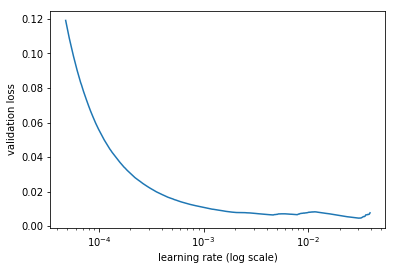

In [235]:
m.sched.plot(100) #new

Train on small sample. Very fast.

In [236]:
lr = 1e-3 #new

In [237]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1) #new

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.002187   0.001506   0.038682  
    1      0.001205   0.000764   0.027551                       
    2      0.000882   0.00055    0.023373                        
    3      0.000702   0.000427   0.020574                        
    4      0.000561   0.000338   0.018315                        



[array([0.00034]), 0.018314909652614595]

In [238]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1) 

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.000453   0.000245   0.015596  
    1      0.000372   0.000195   0.013909                        
    2      0.000314   0.000168   0.012886                        
    3      0.000279   0.000153   0.012299                        
    4      0.000261   0.000146   0.012027                        



[array([0.00015]), 0.012026625890480263]

In [239]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1) 

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.000246   0.00014    0.011756  
    1      0.000237   0.000133   0.011478                        
    2      0.000214   0.000129   0.01127                         
    3      0.000196   0.000125   0.011103                        
    4      0.000197   0.000119   0.010848                        



[array([0.00012]), 0.010847916508867569]

In [240]:
m.fit(lr, 1, metrics=[exp_rmspe], cycle_len=8)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.000249   0.000174   0.01311   
    1      0.000214   0.000138   0.011709                        
    2      0.000187   0.000147   0.012015                        
    3      0.000166   0.000116   0.010728                        
    4      0.000151   0.000109   0.010359                        
    5      0.000135   0.000104   0.010165                        
    6      0.000127   0.0001     0.009946                        
    7      0.000122   0.000101   0.010003                        



[array([0.0001]), 0.010002724922620727]

In [241]:
lr = lr/10
m.fit(lr, 1, metrics=[exp_rmspe], cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.000124   0.000101   0.009991  
    1      0.00012    0.000101   0.010007                        
    2      0.000114   0.000102   0.010012                        
    3      0.000116   0.0001     0.009926                        



[array([0.0001]), 0.00992554753525826]

In [242]:
m.save('small_sample_trained')

### Train on All data

run on all data

In [243]:
joined = pd.read_feather(f'{PATH}joinedmerged_0sales_final')
joined_test = pd.read_feather(f'{PATH}joinedmerged_test_final')

In [244]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']
n = len(joined); n

844338

In [245]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

In [246]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [247]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [248]:
apply_cats(joined_test, joined)

In [249]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [250]:
samp_size = n

In [251]:
joined = joined.set_index("Date")

In [252]:
df, y, nas, mapper = proc_df(joined, 'Sales', do_scale=True)

In [253]:
yl = np.log(y)

In [254]:
joined_test = joined_test.set_index("Date")
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [255]:
df_test.shape

(41088, 38)

In [256]:
train_ratio = 0.75
train_size = int(samp_size * train_ratio); train_size

633253

In [257]:
# set the validation set to be the last 25%
val_idx = list(range(train_size, len(df)))
len(val_idx)

211085

In [258]:
val_idx[:10]

[633253,
 633254,
 633255,
 633256,
 633257,
 633258,
 633259,
 633260,
 633261,
 633262]

In [259]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

In [260]:
max_log_y = np.max(yl)
yll = yl/max_log_y

In [261]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, 
                                       yll.astype(np.float32), cat_flds=cat_vars, 
                                       bs=128,test_df=df_test)

In [262]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [263]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

I also used an unusual small dropout 0.02 after the input layer to improve the generalization. The reasoning is that the 0.02 dropout will randomly remove one small feature or a few dimensions of large features and the model should still be able to get similar result based on the remaining features.

In [264]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.02, 1, [1000,500], [0.01,0.001]) 

In [265]:
m.lr_find(start_lr=1e-7, end_lr=1e-4) #0.75

epoch      trn_loss   val_loss                                    
    0      0.004464   0.00546   



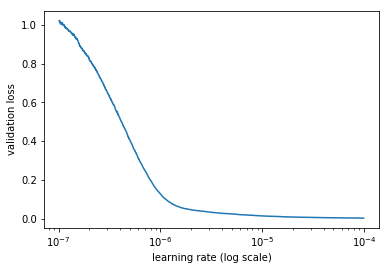

In [266]:
m.sched.plot() #0.75

In [267]:
lr = 2e-7 

In [268]:
m.fit(lr, 3, metrics=[exp_rmspe]) 

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.046666   0.064214   0.244677  
    1      0.019702   0.025203   0.157907                        
    2      0.011559   0.014284   0.117488                        



[array([0.01428]), 0.11748794430658958]

In [269]:
m.fit(lr, 2, metrics=[exp_rmspe],cycle_len=4,cycle_mult=2) 

epoch      trn_loss   val_loss   exp_rmspe                        
    0      0.0096     0.011327   0.104702  
    1      0.008102   0.00988    0.097731                         
    2      0.007596   0.009395   0.095525                         
    3      0.007774   0.009325   0.095133                         
    4      0.006896   0.008255   0.089643                         
    5      0.006203   0.007527   0.08548                          
    6      0.005877   0.00707    0.082969                         
    7      0.005636   0.006794   0.081426                         
    8      0.005459   0.006612   0.080351                         
    9      0.005435   0.006514   0.079755                         
    10     0.005183   0.006484   0.079584                         
    11     0.005259   0.006481   0.079561                         



[array([0.00648]), 0.07956148020075979]

In [270]:
m.save('full_sample_trained_final')

## END

### Test

In [207]:
x,y=m.predict_with_targs(is_test= True)

In [209]:
y = y*max_log_y 

In [ ]:
exp_rmspe(x,y)

In [212]:
pred_test=m.predict(True)
pred_test = pred_test*max_log_y 

pred_test = np.exp(pred_test)

joined_test['Sales']=pred_test

In [215]:
csv_fn=f'{PATH}tmp/sub.csv'

In [216]:
joined_test[['Id','Sales']].to_csv(csv_fn, index=False)

In [219]:
predictions = pd.read_csv(f'{PATH}tmp/sub.csv')

In [221]:
predictions.shape

(41088, 2)

In [ ]:
FileLink(csv_fn)

In [217]:
??FileLink

## RF

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
((val,trn), (y_val,y_trn)) = split_by_idx(val_idx, df.values, yl)

In [ ]:
m = RandomForestRegressor(n_estimators=40, max_features=0.99, min_samples_leaf=2,
                          n_jobs=-1, oob_score=True)
m.fit(trn, y_trn);

In [ ]:
preds = m.predict(val)
m.score(trn, y_trn), m.score(val, y_val), m.oob_score_, exp_rmspe(preds, y_val)

### Diving into code base

In [ ]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False, is_reg=True, is_multi=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range
        self.is_reg = is_reg
        self.is_multi = is_multi

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if not self.is_reg:
            if self.is_multi:
                x = F.sigmoid(x)
            else:
                x = F.log_softmax(x)
        elif self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
